[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/StatMixedML/LightGBMLSS/blob/master/examples/simulation_example_Poisson.ipynb)

# Imports

In [12]:
from lightgbmlss.model import *
from lightgbmlss.distributions.Poisson import *

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data

In [2]:
def custom_transform(y, constr_val):
    # Apply a custom transformation to restrict y between 0 and constr_val
    transformed_y = np.abs(y)  # Example transformation: logarithmic
    constrained_y = constr_val * transformed_y / np.max(transformed_y)  # Scale to desired range
    int_y = constrained_y.astype(int)
    return int_y

# Generate a custom dataset
X, y = make_regression(n_samples=5000, n_features=10, n_informative=2, random_state=123)

# Apply the custom transformation
y = custom_transform(y, 50)

# Make a dataframe for visualization
X = pd.DataFrame(X, columns=[f"x_{i+1}" for i in range(X.shape[1])])

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = lgb.Dataset(X_train, label=y_train)

# Distribution Selection

In [3]:
# Specifies Poisson distribution with relu response function and option to stabilize Gradient/Hessian.
lgblss = LightGBMLSS(
    Poisson(stabilization="None",              # Options are "None", "MAD", "L2".
            response_fn="relu")                # Function to transform the rate-parameter, e.g., "exp", "softplus" or "relu".
)

# Hyper-Parameter Optimization

In [4]:
# Any LightGBM hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
    # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"boosting": ["categorical", ["gbdt", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
        # param_name: str, Name of the parameter
        # value: int, Value of the parameter
    # Example: {"gpu_id": ["none", [0]]}

param_dict = {
    "eta":                      ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":                ["int",   {"low": 1,      "high": 10,    "log": False}],
    "subsample":                ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "feature_fraction":         ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "boosting":                 ["categorical", ["gbdt"]],
}

np.random.seed(123)
opt_param = lgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-05-23 17:49:20,692] A new study created in memory with name: LightGBMLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\LightGBMLSS-Dam57Fpb\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/05:00

[I 2023-05-23 17:49:24,165] Trial 0 finished with value: 3980.3492107495294 and parameters: {'eta': 2.699359681957599e-05, 'max_depth': 6, 'subsample': 0.2999341545563561, 'feature_fraction': 0.5556034158427867, 'boosting': 'gbdt'}. Best is trial 0 with value: 3980.3492107495294.
[I 2023-05-23 17:49:26,086] Trial 1 finished with value: 2518.34168110926 and parameters: {'eta': 0.45895527487414584, 'max_depth': 4, 'subsample': 0.9457458063686266, 'feature_fraction': 0.7992492274530714, 'boosting': 'gbdt'}. Best is trial 1 with value: 2518.34168110926.
[I 2023-05-23 17:49:28,467] Trial 2 finished with value: 1973.077981251329 and parameters: {'eta': 0.1076719026212947, 'max_depth': 2, 'subsample': 0.9949902525970964, 'feature_fraction': 0.8547024470705862, 'boosting': 'gbdt'}. Best is trial 2 with value: 1973.077981251329.
[I 2023-05-23 17:49:30,875] Trial 3 finished with value: 3222.7300283960785 and parameters: {'eta': 0.02108376076622654, 'max_depth': 2, 'subsample': 0.4446423511770703

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
lgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = lgblss.predict(X_test,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = lgblss.predict(X_test,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = lgblss.predict(X_test,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,29,25,38,31,42,30,36,23,21,29,...,24,39,38,38,21,22,27,27,26,27
1,27,18,38,23,21,27,17,36,33,23,...,25,26,36,20,27,31,21,21,20,17
2,17,21,13,19,14,20,23,16,14,9,...,14,14,14,21,13,11,12,19,13,20
3,7,13,10,9,9,11,10,9,8,9,...,7,13,11,7,8,11,10,8,11,9
4,6,9,6,7,3,4,7,6,3,7,...,5,6,10,6,6,5,5,6,9,7


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,22,40
1,17,34
2,11,24
3,5,14
4,3,11


In [9]:
pred_params.head()

,rate
0,31.458658
1,25.565571
2,16.973503
3,9.111122
4,6.517088


# SHAP Interpretability

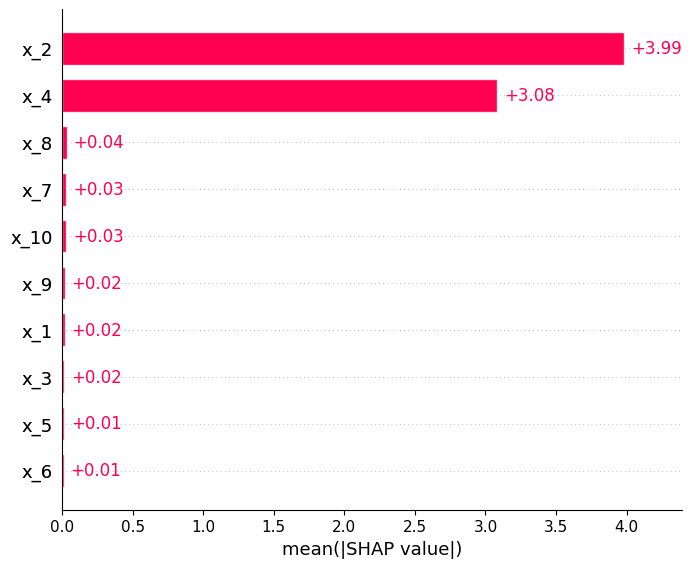

In [10]:
# Feature Importance of rate parameter
lgblss.plot(X_test,
            parameter="rate",
            plot_type="Feature_Importance")

# Plot Predicted vs. True

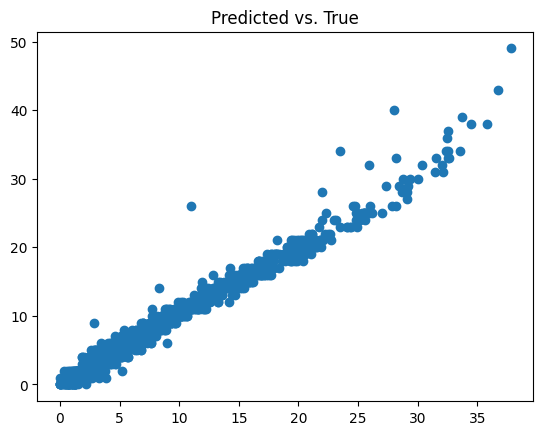

In [11]:
plt.scatter(pred_params["rate"], y_test)
plt.title("Predicted vs. True")
plt.show()